# Multi-RF Ensemble (with optional feature selection)

## 1. Load the packages and Data

In [2]:
#load packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from copy import deepcopy

In [3]:
#load the data
train_data = pd.read_csv("train.csv").drop(columns= 'id')#remove id since this is irrelevant
test_data = pd.read_csv("test.csv").drop(columns= 'id')#remove id since this is irrelevant

#replace empty data entries with the median of that feature
mean_train_data = train_data.fillna(train_data.median())
mean_test_data = test_data.fillna(test_data.median())
print(mean_train_data.head())
print(mean_test_data.head())


   last_price     mid  opened_position_qty   closed_position_qty  \
0      3842.4  3842.6                   1.0                  1.0   
1      3842.8  3843.4                   6.0                 49.0   
2      3844.0  3844.3                   7.0                 77.0   
3      3843.8  3843.4                   3.0                 34.0   
4      3843.2  3843.1                   3.0                 38.0   

   transacted_qty  d_open_interest    bid1    bid2    bid3    bid4  ...  \
0           103.0                0  3842.4  3842.0  3841.8  3841.0  ...   
1            55.0              -43  3843.0  3842.8  3842.4  3842.0  ...   
2            84.0              -69  3843.8  3843.6  3843.2  3843.0  ...   
3            37.0              -30  3843.0  3842.8  3842.4  3842.0  ...   
4            41.0              -35  3842.8  3842.4  3842.0  3841.8  ...   

   bid2vol  bid3vol  bid4vol  bid5vol  ask1vol  ask2vol  ask3vol  ask4vol  \
0        1        6       14        6        6        1        

## Outliers

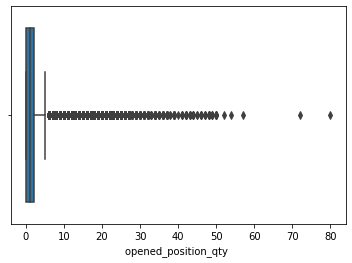

In [4]:
#training data outlieres in opened_position_qty
import seaborn as sns
sns.boxplot(x=train_data['opened_position_qty '])

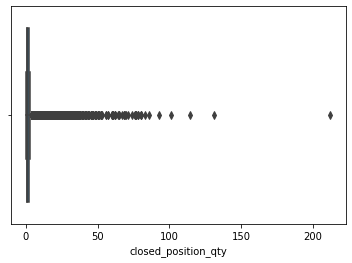

In [5]:
#training data outlieres in closed_position_qty
sns.boxplot(x=train_data['closed_position_qty'])

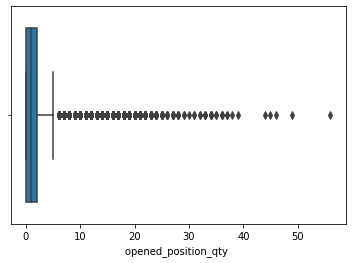

In [6]:
#testing data outlieres in opened_position_qty
sns.boxplot(x=test_data['opened_position_qty '])

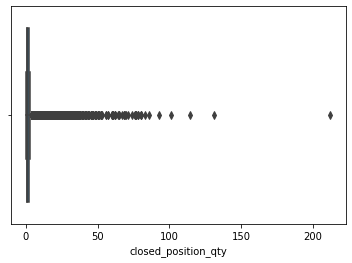

In [7]:
#testing data outlieres in closed_position_qty
sns.boxplot(x = train_data['closed_position_qty'])

## 1a: Data Conditioning (Optional)

### (a) Feature Selection

In [63]:
# Manually consider new features
# MEANS
mean_train_data['bid_mean'] = mean_train_data[['bid1','bid2','bid3','bid4','bid5']].mean(axis=1)
mean_train_data['ask_mean'] = mean_train_data[['ask1','ask2','ask3','ask4','ask5']].mean(axis=1)
mean_train_data['bid_vol_mean'] = mean_train_data[['bid1vol','bid2vol','bid3vol','bid4vol','bid5vol']].mean(axis=1)
mean_train_data['ask_vol_mean'] = mean_train_data[['ask1vol','ask2vol','ask3vol','ask4vol','ask5vol']].mean(axis=1)

# STANDARD DEV
mean_train_data['bid_std'] = mean_train_data[['bid1','bid2','bid3','bid4','bid5']].std(axis=1)
mean_train_data['ask_std'] = mean_train_data[['ask1','ask2','ask3','ask4','ask5']].std(axis=1)
mean_train_data['bid_vol_std'] = mean_train_data[['ask1vol','bid2vol','bid3vol','bid4vol','bid5vol']].std(axis=1)
mean_train_data['ask_vol_std'] = mean_train_data[['ask1vol','ask2vol','ask3vol','ask4vol','ask5vol']].std(axis=1)

# RANGE
mean_train_data['bid_range'] = mean_train_data[['bid1','bid2','bid3','bid4','bid5']].max(axis=1) - mean_train_data[['bid1','bid2','bid3','bid4','bid5']].min(axis=1)
mean_train_data['ask_range'] = mean_train_data[['ask1','ask2','ask3','ask4','ask5']].max(axis=1) - mean_train_data[['ask1','ask2','ask3','ask4','ask5']].min(axis=1)
mean_train_data['bid_vol_range'] = mean_train_data[['ask1vol','bid2vol','bid3vol','bid4vol','bid5vol']].max(axis=1) - mean_train_data[['ask1vol','bid2vol','bid3vol','bid4vol','bid5vol']].min(axis=1)
mean_train_data['ask_vol_range'] = mean_train_data[['ask1vol','ask2vol','ask3vol','ask4vol','ask5vol']].max(axis=1) - mean_train_data[['ask1vol','ask2vol','ask3vol','ask4vol','ask5vol']].min(axis=1)

# DIFFERENCES
mean_train_data['mid_last_diff'] = mean_train_data['mid'] - mean_train_data['last_price']
mean_train_data['open_close_diff'] = mean_train_data['opened_position_qty '] - mean_train_data['closed_position_qty']
mean_train_data['bid_ask_diff'] = bid_mean - ask_mean
mean_train_data['bid_ask_vol_diff'] = bid_vol_mean - ask_vol_mean

print(mean_train_data.columns.to_list())
mean_train_data = mean_train_data[['last_price', 'mid', 'opened_position_qty ', 'closed_position_qty', 'transacted_qty', 'd_open_interest', 'bid1', 'bid2', 'bid3', 'bid4', 'bid5', 'ask1', 'ask2', 'ask3', 'ask4', 'ask5', 'bid1vol', 'bid2vol', 'bid3vol', 'bid4vol', 'bid5vol', 'ask1vol', 'ask2vol', 'ask3vol', 'ask4vol', 'ask5vol', 'bid_mean', 'ask_mean', 'bid_vol_mean', 'ask_vol_mean', 'bid_std', 'ask_std', 'bid_vol_std', 'ask_vol_std', 'bid_range', 'ask_range', 'bid_vol_range', 'ask_vol_range', 'mid_last_diff', 'open_close_diff', 'bid_ask_diff', 'bid_ask_vol_diff','y']]
print(mean_train_data.head())

['last_price', 'mid', 'opened_position_qty ', 'closed_position_qty', 'transacted_qty', 'd_open_interest', 'bid1', 'bid2', 'bid3', 'bid4', 'bid5', 'ask1', 'ask2', 'ask3', 'ask4', 'ask5', 'bid1vol', 'bid2vol', 'bid3vol', 'bid4vol', 'bid5vol', 'ask1vol', 'ask2vol', 'ask3vol', 'ask4vol', 'ask5vol', 'y', 'bid_mean', 'ask_mean', 'bid_vol_mean', 'ask_vol_mean', 'bid_std', 'ask_std', 'bid_vol_std', 'ask_vol_std', 'bid_range', 'ask_range', 'bid_vol_range', 'ask_vol_range', 'mid_last_diff', 'open_close_diff', 'bid_ask_diff', 'bid_ask_vol_diff']
   last_price     mid  opened_position_qty   closed_position_qty  \
0      3842.4  3842.6                   1.0                  1.0   
1      3842.8  3843.4                   6.0                 49.0   
2      3844.0  3844.3                   7.0                 77.0   
3      3843.8  3843.4                   3.0                 34.0   
4      3843.2  3843.1                   3.0                 38.0   

   transacted_qty  d_open_interest    bid1    bid2

### repeat on the testing set

In [86]:
# Manually consider new features
# MEANS
mean_test_data['bid_mean'] = mean_test_data[['bid1','bid2','bid3','bid4','bid5']].mean(axis=1)
mean_test_data['ask_mean'] = mean_test_data[['ask1','ask2','ask3','ask4','ask5']].mean(axis=1)
mean_test_data['bid_vol_mean'] = mean_test_data[['bid1vol','bid2vol','bid3vol','bid4vol','bid5vol']].mean(axis=1)
mean_test_data['ask_vol_mean'] = mean_test_data[['ask1vol','ask2vol','ask3vol','ask4vol','ask5vol']].mean(axis=1)

# STANDARD DEV
mean_test_data['bid_std'] = mean_test_data[['bid1','bid2','bid3','bid4','bid5']].std(axis=1)
mean_test_data['ask_std'] = mean_test_data[['ask1','ask2','ask3','ask4','ask5']].std(axis=1)
mean_test_data['bid_vol_std'] = mean_test_data[['ask1vol','bid2vol','bid3vol','bid4vol','bid5vol']].std(axis=1)
mean_test_data['ask_vol_std'] = mean_test_data[['ask1vol','ask2vol','ask3vol','ask4vol','ask5vol']].std(axis=1)

# RANGE
mean_test_data['bid_range'] = mean_test_data[['bid1','bid2','bid3','bid4','bid5']].max(axis=1) - mean_test_data[['bid1','bid2','bid3','bid4','bid5']].min(axis=1)
mean_test_data['ask_range'] = mean_test_data[['ask1','ask2','ask3','ask4','ask5']].max(axis=1) - mean_test_data[['ask1','ask2','ask3','ask4','ask5']].min(axis=1)
mean_test_data['bid_vol_range'] = mean_test_data[['ask1vol','bid2vol','bid3vol','bid4vol','bid5vol']].max(axis=1) - mean_test_data[['ask1vol','bid2vol','bid3vol','bid4vol','bid5vol']].min(axis=1)
mean_test_data['ask_vol_range'] = mean_test_data[['ask1vol','ask2vol','ask3vol','ask4vol','ask5vol']].max(axis=1) - mean_test_data[['ask1vol','ask2vol','ask3vol','ask4vol','ask5vol']].min(axis=1)

# DIFFERENCES
mean_test_data['mid_last_diff'] = mean_test_data['mid'] - mean_test_data['last_price']
mean_test_data['open_close_diff'] = mean_test_data['opened_position_qty '] - mean_test_data['closed_position_qty']
mean_test_data['bid_ask_diff'] = bid_mean - ask_mean
mean_test_data['bid_ask_vol_diff'] = bid_vol_mean - ask_vol_mean

print(mean_test_data.columns.to_list())
mean_test_data = mean_test_data[['last_price', 'mid', 'opened_position_qty ', 'closed_position_qty', 'transacted_qty', 'd_open_interest', 'bid1', 'bid2', 'bid3', 'bid4', 'bid5', 'ask1', 'ask2', 'ask3', 'ask4', 'ask5', 'bid1vol', 'bid2vol', 'bid3vol', 'bid4vol', 'bid5vol', 'ask1vol', 'ask2vol', 'ask3vol', 'ask4vol', 'ask5vol', 'bid_mean', 'ask_mean', 'bid_vol_mean', 'ask_vol_mean', 'bid_std', 'ask_std', 'bid_vol_std', 'ask_vol_std', 'bid_range', 'ask_range', 'bid_vol_range', 'ask_vol_range', 'mid_last_diff', 'open_close_diff', 'bid_ask_diff', 'bid_ask_vol_diff']]
print(mean_test_data.head())

['last_price', 'mid', 'opened_position_qty ', 'closed_position_qty', 'transacted_qty', 'd_open_interest', 'bid1', 'bid2', 'bid3', 'bid4', 'bid5', 'ask1', 'ask2', 'ask3', 'ask4', 'ask5', 'bid1vol', 'bid2vol', 'bid3vol', 'bid4vol', 'bid5vol', 'ask1vol', 'ask2vol', 'ask3vol', 'ask4vol', 'ask5vol', 'bid_mean', 'ask_mean', 'bid_vol_mean', 'ask_vol_mean', 'bid_std', 'ask_std', 'bid_vol_std', 'ask_vol_std', 'bid_range', 'ask_range', 'bid_vol_range', 'ask_vol_range', 'mid_last_diff', 'open_close_diff', 'bid_ask_diff', 'bid_ask_vol_diff']
   last_price     mid  opened_position_qty   closed_position_qty  \
0      5178.4  5178.3                   1.0                 11.0   
1      5133.0  5132.9                   1.0                  0.0   
2      5177.4  5178.0                   2.0                  0.0   
3      5093.6  5093.9                   0.0                  2.0   
4      5189.2  5189.2                   1.0                  1.0   

   transacted_qty  d_open_interest    bid1    bid2    b

### Rescaling: not used

In [129]:
# OPTIONAL: rescale the data
#test_mean = mean_test_data.mean().iloc[0:26]

#train_mean = np.mean(train_data[:,0:26])
#train_std = np.std(train_data[:,0:26])

#train_data[:,0:26] = (train_data[:,0:26] - train_mean)/train_std
#val_data[:,0:26] = (val_data[:,0:26] - train_mean)/train_std
#mean_test_data = (mean_test_data - train_mean)/train_std

#print(mean_test_data.head())

   last_price       mid  opened_position_qty   closed_position_qty  \
0    1.693579  1.693529             -0.926989            -0.921927   
1    1.670600  1.670549             -0.926989            -0.927495   
2    1.693073  1.693377             -0.926483            -0.927495   
3    1.650657  1.650809             -0.927495            -0.926483   
4    1.699046  1.699046             -0.926989            -0.926989   

   transacted_qty  d_open_interest      bid1      bid2      bid3      bid4  \
0       -0.921421        -0.932557  1.693478  1.693377  1.693276  1.693174   
1       -0.926989        -0.926989  1.670499  1.670397  1.670296  1.670195   
2       -0.926483        -0.926483  1.692972  1.692769  1.692668  1.692567   
3       -0.926483        -0.928001  1.650455  1.650354  1.650252  1.649949   
4       -0.927495        -0.927495  1.698843  1.698742  1.698641  1.698540   

   ...   bid1vol   bid2vol   bid3vol   bid4vol   bid5vol   ask1vol   ask2vol  \
0  ... -0.925977 -0.919396 -0.

## Random Search hyperparameter optimization

In [ ]:
X_initial = mean_train_data.drop(['y'],axis=1).to_numpy()
y_initial = mean_train_data['y'].to_numpy()

from sklearn.model_selection import RandomizedSearchCV #For Random search optimization
random_search = {'criterion': ['entropy', 'gini'],#For the random search i'll try both entro and Gini
               'max_depth': [10,50,100,200] + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [10,40,80,100,200],
               'min_samples_split': list(np.linspace(0.1,1.0,10, endpoint = True)),
               'n_estimators': [1,10,100,1000]} #change this back if threshold works

clf = RandomForestClassifier()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 50, 
                               cv = 4, verbose= 2, random_state= 101, n_jobs = -1)
model.fit(X_initial,y_initial)
print(model.best_params_)

### Feature Selection with SKLearn

In [54]:
X_initial = mean_train_data.drop(['y'],axis=1).to_numpy()
y_initial = mean_train_data['y'].to_numpy()

from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(estimator=RandomForestClassifier(n_estimators = 1000, min_samples_leaf = 87))
selector.fit(X_initial,y_initial)

AttributeError: 'SelectFromModel' object has no attribute 'print_support'

In [90]:
sel_i = selector.get_support()
feature_i = []
for i, include in enumerate(sel_i):
    if include == True:
        feature_i.append(i)
print(feature_i)

[4, 16, 21, 29, 38, 40, 41]


It looks like the most important columns are numbers 4, 16, 21, 29, 38, 40, 41. These correspond to the following features:

In [128]:
features = feature_i.copy()
ind = 0
for i, k in enumerate(feature_i):
    features[i] = mean_train_data.columns.to_list()[k]
print(features)
n_features = len(features)

['transacted_qty', 'bid1vol', 'ask1vol', 'ask_vol_mean', 'mid_last_diff', 'bid_ask_diff', 'bid_ask_vol_diff']


## Create the new training feature vectors

In [129]:
mean_test_data_sel = mean_test_data[features]
features_train = features.append('y')
mean_train_data_sel = mean_train_data[features]
print(mean_train_data_sel.head())
print(mean_test_data_sel.head())

   transacted_qty  bid1vol  ask1vol  ask_vol_mean  mid_last_diff  \
0           103.0        8        6           4.0            0.2   
1            55.0        7        1           4.6            0.6   
2            84.0        3        1           8.0            0.3   
3            37.0       10        2           4.6           -0.4   
4            41.0       14        1           6.2           -0.1   

   bid_ask_diff  bid_ask_vol_diff  y  
0         -2.00               3.0  1  
1         -1.92               1.6  0  
2         -2.04               0.2  0  
3         -2.00               3.6  1  
4         -2.28               0.6  1  
   transacted_qty  bid1vol  ask1vol  ask_vol_mean  mid_last_diff  \
0            12.0        3        1           2.6  -1.000000e-01   
1             1.0        1        4           3.0  -1.000000e-01   
2             2.0        8        7           3.8   6.000000e-01   
3             2.0        8        1           4.2   3.000000e-01   
4             0.0

## 2. Split the training data into however many sets

In [130]:
# test-train split
train_data, val_data = train_test_split(mean_train_data_sel.to_numpy(), train_size=0.8, shuffle=False)
submission_test = mean_test_data_sel.to_numpy()

7


In [114]:
def classification_score(real_y,y_score):
	"""
	This function returns the classification error between two equally-sized vectors of
	labels; this is the fraction of samples for which the labels differ.
    
	Inputs:
    	y: (N, ) shaped array of predicted labels
    	real_y: (N, ) shaped array of true labels
	Output:
    	Scalar classification error
	"""
	return roc_auc_score(real_y,y_score)

## 3. Define & Train Model

In [135]:
Models = []
for k in range(n_splits): # for each training data subset
    # pick out the features and labels for this subset
    X_train = train_splits[k][:,0:n_features]
    #print(X_train[0:10,:])
    y_train = train_splits[k][:,n_features]
    #print(y_train[0:10])
    
    # create a random forest with the desired parameters
    n_estimators = 50
    RF = RandomForestClassifier(n_estimators = n_estimators, criterion = 'gini',min_samples_leaf=87)
    RF.fit(X_train, y_train)
    output = RF.predict_proba(X_train)[:,1]
    
    Models.append(deepcopy(RF))
    if (k+1)%100 ==0:
        print('Model %2f out of %2f complete'% (k+1,n_splits), '  Training ROC ',classification_score(y_train,output))


In [145]:
print(classification_score(y_train,output))

0.6946119664402051


## 4. Validate the Model

In [137]:
# specify the same validation set for all models
X_val = val_data[:,0:n_features]
y_val = val_data[:,n_features]

Pred_probas = []
Preds = []
mean_pred = np.zeros(len(y_val))

for k, model in enumerate(Models):
    pred = model.predict_proba(X_val)[:,1]
    Preds.append(deepcopy(pred))
    mean_pred += pred
    
    scorek = classification_score(y_val,pred)
    if (k+1)%10 ==0:
        print('Model %.0f has validation score %.4f' % (k+1,scorek))
    
mean_pred /= n_splits
print(classification_score(y_val,mean_pred))

Model 10 has validation score 0.6357
Model 20 has validation score 0.6360
Model 30 has validation score 0.6379
Model 40 has validation score 0.6351
Model 50 has validation score 0.6401
0.644178647455844


In [138]:
classification_score(y_val,mean_pred)

0.644178647455844

In [139]:
np.std(mean_pred)

0.09690947022598619

## 5. Predict the submission set

In [141]:
X_submit = submission_test
Preds = []
mean_pred_submit = np.zeros(len(X_submit))

for k, model in enumerate(Models):
    pred = model.predict_proba(X_submit)[:,1]
    Preds.append(deepcopy(pred))
    mean_pred_submit += pred
    if (k+1)%10 ==0:
        print('Model %.0f of %.0f evaluated' % (k+1,n_splits))
    
mean_pred_submit /= n_splits

Model 10 of 50 evaluated
Model 20 of 50 evaluated
Model 30 of 50 evaluated
Model 40 of 50 evaluated
Model 50 of 50 evaluated


In [142]:
test_data = pd.read_csv("test.csv",index_col=0)
test_data['Predicted'] = mean_pred_submit
test_data[['Predicted']].to_csv('submission_100RFs.csv')

In [143]:
np.std(mean_pred_submit)

0.09011865649821607

## 6. (Optional) Save the Models

In [144]:
import pickle
pkl_filename = "RF_feature_reduced_50splits.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump((Models), file)

NameError: name 'train_mean' is not defined